# Trajectory clustering의 의미
1. 출발지->도착지가 같은 상황의 clustering이면 당연히 cluster는 1개 아닌가? 의미가 있나?  
   *서로다른 출발지 -> 서로다른 도착지의 경로간 비슷한 경로 clustering이 아니고 특징, 패턴탐지를 위해서 함.  
   같은 출발–도착이라도 날아가는 패턴(경로)는 다음 변수에 따라 항상 달라짐.*
   - 이륙 활주로 방향
   - 착륙 활주로 방향
   - 혼잡도
   - 바람 방향
   - 특정 시간대의 쏠림(Arrival Route)
   - SID(Standard Instrument Departure)
   - STAR(Standard Arrival) 절차 선택
   - 특정 구간에서의 회피 회전(avoidance turn)
   <br><br> 
2. 이거완전 다항회귀처럼 여러 데이터를 반영하는 하나의 경로찾기 아닌가?  
   *다수의 곡선들을 ‘형태 기반’으로 그룹화하는 작업. 다항회귀랑은 다름.  
   회귀는 '예측', clustering은 '패턴분류'. 탐색적 작업에 가까움*
   <br><br>
3. 한 줄 요약  
   *곡선 모양(trajectory)을 일정 길이로 샘플링해 벡터로 만들고,  
   곡선 사이의 유사도를 거리 기반으로 계산해  
   HDBSCAN이 밀도 기반으로 패턴을 찾는 것”*
   - 거리계산은 벡터간에만 가능 -> 벡터로 만들기 위해 여러좌표를 모아서 flatten
   - 곡선을 비교하려면 두 곡선이 같은 길이의 point sequence여야 함 -> 벡터간 거리 계산시 x1,y1,z1과 x2,y2를 비교할 수 는 없으니 -> 경로간 좌표개수(차원) 통일 -> resampling or interpolation
   - 근데 곡선간 비교를 위해 왜 flatten 함? -> curve는 본질적으로 고차원 벡터의 한 점이다(위치별 여러 점의 정보가 고차원화되어 그걸 한 점으로 표현된) = 여러 벡터의 합이 아니라 고차원벡터로 인코딩
   - 유사하게 이미지 데이터도 3차원 행렬이지만 연산시 1차원의 flatten해서 진행 = 이미지 자체는 고차원 벡터 하나에 대응됨
   - 따라서 곡선간의 거리 비교도 결국 고차원 벡터 두 점 사이의 거리

## Import library

In [ ]:
!pip install umap-learn

In [ ]:
!pip install "scikit-learn==1.5.2"

In [ ]:
!pip install "protobuf==3.20.*"

In [ ]:
!pip uninstall -y sklearn-compat
!pip uninstall -y imbalanced-learn
!pip uninstall -y category-encoders

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install umap-learn==0.5.9.post2

In [1]:

import os
import pandas as pd
import xml.etree.ElementTree as ET

from pyproj import Transformer
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import folium

2025-11-25 03:11:38.063535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764040298.089128     138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764040298.096792     138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Input day text('Thu') and download all the day tragetory files
* 목표는 최소 50개 이상, 약 100\~200개 이상의 경로수집
* 그럼 주 패턴이 2~4개로 나뉠 것으로 예상
* 부패턴이 나타나기 시작할 것으로 예상
* HDBSCAN이 안정적으로 condensed tree 형성 기대

In [ ]:
# "https://www.flightaware.com/live/findflight?origin=RKSI&destination=RJFF" 진입
# selenium으로 요일 텍스트 'Thu'에 해당하는 링크들 선회
# 클릭해서 새 driver로 전환
# 해당 driver링크 저장 ("https://www.flightaware.com/live/flight/ESR649/history/20251113/0925Z/RKSI/RJFF")
# 위 과정 반복
# 끝나면 url링크 + '/google_earth' 처리 ("https://www.flightaware.com/live/flight/ESR649/history/20251113/0925Z/RKSI/RJFF/google_earth")
# 끝나면 각 링크 순회 -> 파일링크라서 자동 다운로드 됨
# 이후 kaggle dataset에 업로드

# 완성시 매일 특정시각 자동화도 고려

## Upload all downloaded files and integrate
> KML : XML 기반, XML은 태그기반의 트리 구조 (HTML처럼)  
> tree → root → child → child … 이런 계층이 존재  
> 다만 화면 표시용이 아닌 데이터를 저장하고 전달하기 위한 언어
> 속성끼리 자연스럽게 묶이고 그룹화되는 구조 표현에 적합
> 계층적 데이터 표현(지도/항공/위치/기업시스템설정), schema를 통한 엄밀한 데이터구조 검증(규격 절대사수: 금융/공공기관), 문서형태의 구조(RSS)에 사용됨
* df 해당날짜의 항공편별(INC-FUK) 데이터  
  flight: 항공편 (*경로마다 기록포인트 개수가 다름*)    
  time: 시각 (*시간은 UTC기준. 홈페이지는 UTC-5(EST, 미국 동부표준시간대)로 나와서 5만큼 차이남*)    
  longitude: 경도  
  latitude: 위도  
  altitude: 고도(ft)  

In [2]:
def load_flight_data(folder):
    """
    folder : KML 파일들이 들어 있는 폴더 경로
    return : df
    """
    # folder = "/kaggle/input/flight-trajectory-icn-fuk-20251113"
    
    df_list = []
    
    ns = {
        "k": "http://www.opengis.net/kml/2.2",
        "gx": "http://www.google.com/kml/ext/2.2"
    } # namespace = 태그의 포인터, 태그이름 같아도 구별필요. 접근용 식별자

    # 폴더 내 모든 파일 순회
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)

        print(f"Processing: {fname}...")
        tree = ET.parse(fpath)
        root = tree.getroot()

        placemarks = root.findall(".//k:Placemark", ns)

        # 경로있는 placemark 탐색
        track_pm = None
        for pm in placemarks:
            track = pm.find("gx:Track", ns)
            if track is not None:
                track_pm = track
                flight = pm.find("k:name", ns).text
                break

        if track_pm is None:
            raise ValueError(f"경로정보를 찾을 수 없습니다: {fname}") # 강제 에러발생

        # 경로정보 추출
        whens = [w.text for w in track_pm.findall("k:when", ns)]
        coords = [c.text for c in track_pm.findall("gx:coord", ns)]

        flight_id = f"{flight}_{whens[0]}"
        rows = []
        for when, coord in zip(whens, coords):
            when = when.replace("T", " ").replace("Z", "") # 2025-11-13T07:10:08Z
            time = pd.to_datetime(when)
            lon, lat, alt = coord.split()
            rows.append([flight_id, time, float(lon), float(lat), float(alt)*0.3048])
            # alt는 feet라서 meter로 변환

        df_temp = pd.DataFrame(rows, 
                               columns=['flight_id', 'time', 'longitude', 'latitude', 'altitude'])
        df_list.append(df_temp)

    df = pd.concat(df_list, ignore_index=True) # 기존 index를 무시하고 새로 부여. concat에서는 거의 필수
    print("변환작업 완료!")
    
    return df

In [ ]:
folder = "/kaggle/input/flight-trajectory-icn-fuk-20251113"
df = load_flight_data(folder)

In [ ]:
df.head()

In [ ]:
# 파일로 저장
date = folder.split("/")[-1].split("-")[-1] # 예: "20251113"
df.to_csv(f"flight_data_{date}.csv", index=False, encoding="utf-8")

## Preprocessing
* 좌표계 변환 (lat/lon->Euclid 공간): UTM(Universal Transverse Mercator), local ENU로 변환하는 편
  * UTM (Universal Transverse Mercator): 지구 전체를 6° 단위 zone으로 나눔, 평면좌표로 투영, meter 단위, 왜곡이 작고 안정적
  * ENU (East-North-Up): 기준점(Reference point)을 하나 잡고 그 점을 0,0,0으로 두는 국소 좌표, 특정 지역, 작은 영역에서 매우 정밀, 자율주행 같이 국소지역에 강점
* flight 단위로 grouping
* noise 제거: speed-based filtering(속도기반 제거, 속도가 갑자기 뛴다), Hampel filter(평균말고 중앙값기반으로 outlier 판별 및 대체), Kalman filter(정확도 좋음)
* 경로별 arc-length resampling(곡선길이 조정): sequence, 즉 좌표개수 통일하는 과정
  * 좌표간 거리 계산
  * 누적거리 계산 -> 비행 전체의 진행률 확인용
  * 전체경로함수 f(t)=(x(t),y(t),z(t)) 에서 t를 0~1로 normalization
  * 일정 진행률 별로 좌표 interpolation
  * 모든 경로에 대해서 좌표개수 통일
* 벡터로 flatten
* UMAP dimensionality reduction
---
1. UTM변환: lat, lon만 지구곡면 위 각도(구면좌표계)라서 보정(평면좌표계). alt는 괜찮음
2. Hampel filter적용

### data load

In [3]:
folder = "/kaggle/input/flight-trajectory-icn-fuk-202511"
days = [12,13,15,18,19,20,22]

df_all = []
for d in days:
    df_all.append(load_flight_data(f"{folder}{d}"))

Processing: FlightAware_TWB201_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ASV727_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JNA269_RKSI_RJFF_20251112.kml...
Processing: FlightAware_TWB205_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JJA1407_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JNA261_RKSI_RJFF_20251111.kml...
Processing: FlightAware_JJA1405_RKSI_RJFF_20251112.kml...
Processing: FlightAware_KAL787_RKSI_RJFF_20251111.kml...
Processing: FlightAware_ESR647_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ESR649_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ABL156_RKSI_RJFF_20251111.kml...
Processing: FlightAware_JJA1403_RKSI_RJFF_20251112.kml...
Processing: FlightAware_AAR134_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ESR645_RKSI_RJFF_20251111.kml...
Processing: FlightAware_ASV723_RKSI_RJFF_20251111.kml...
Processing: FlightAware_TWB207_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JNA265_RKSI_RJFF_20251112.kml...
Processing: FlightAware_KAL7

In [4]:
train = pd.concat(df_all, ignore_index=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20897 entries, 0 to 20896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   flight_id  20897 non-null  object        
 1   time       20897 non-null  datetime64[ns]
 2   longitude  20897 non-null  float64       
 3   latitude   20897 non-null  float64       
 4   altitude   20897 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 816.4+ KB


In [6]:
train['flight_id'].nunique()

152

### UTM 변환
* zone = int((lon + 180) / 6) + 1
* 서울(ICN) → 경도 126 → zone 52N  
  후쿠오카(FUK) → 경도 130 → zone 52N
* 둘 다 같은 zone에 있으므로 문제 없음

In [7]:
train.head()

,flight_id,time,longitude,latitude,altitude
0,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:24,126.45264,37.46356,2.4384
1,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:40,126.46169,37.45464,60.3504
2,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:57,126.47443,37.44685,118.5672
3,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:13,126.48787,37.43948,169.4688
4,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:29,126.49903,37.43182,209.0928


In [8]:
# UTM 변환기 설정 (ICN~FUK는 UTM 52N zone이 안정적)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32652", always_xy=True)

# lat/lon → UTM x,y 변환
utm_x = []
utm_y = []

for lon, lat in zip(train["longitude"], train["latitude"]):
    x, y = transformer.transform(lon, lat)
    utm_x.append(x)
    utm_y.append(y)

train["utm_x"] = utm_x
train["utm_y"] = utm_y

In [9]:
train.head()

,flight_id,time,longitude,latitude,altitude,utm_x,utm_y
0,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:24,126.45264,37.46356,2.4384,274709.805784,4.149346e+06
1,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:40,126.46169,37.45464,60.3504,275483.642857,4.148335e+06
2,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:57,126.47443,37.44685,118.5672,276587.516339,4.147440e+06
3,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:13,126.48787,37.43948,169.4688,277754.807436,4.146590e+06
4,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:29,126.49903,37.43182,209.0928,278719.716208,4.145714e+06


### grouping

In [10]:
trajectories = {}

for fid, group in train.groupby("flight_id"): # groupby로 묶고서 key값인 fid(flight id)와 그룹값 반환
    # 시간순 정렬
    group = group.sort_values("time")

    # trajectory = list of (x, y, altitude)
    coords = list(zip(group["utm_x"], group["utm_y"], group["altitude"]))

    trajectories[fid] = coords

In [11]:
trajectories.keys()

dict_keys(['AAR134_2025-11-12T04:36:25Z', 'AAR134_2025-11-13T04:56:02Z', 'AAR134_2025-11-15T04:35:22Z', 'AAR134_2025-11-18T04:31:39Z', 'AAR134_2025-11-19T04:26:45Z', 'AAR134_2025-11-20T04:20:09Z', 'AAR134_2025-11-22T04:26:18Z', 'ABL156_2025-11-11T22:36:09Z', 'ABL156_2025-11-12T22:31:07Z', 'ABL156_2025-11-14T22:27:38Z', 'ABL156_2025-11-17T22:26:58Z', 'ABL156_2025-11-18T22:36:46Z', 'ABL156_2025-11-19T22:32:30Z', 'ABL156_2025-11-21T22:31:37Z', 'ABL158_2025-11-12T02:30:12Z', 'ABL158_2025-11-13T02:31:05Z', 'ABL158_2025-11-15T02:22:54Z', 'ABL158_2025-11-18T02:26:37Z', 'ABL158_2025-11-19T02:29:42Z', 'ABL158_2025-11-20T02:23:22Z', 'ABL158_2025-11-22T02:26:46Z', 'ASV723_2025-11-11T23:26:12Z', 'ASV723_2025-11-12T22:33:15Z', 'ASV723_2025-11-17T22:39:11Z', 'ASV723_2025-11-19T00:38:03Z', 'ASV723_2025-11-19T23:13:47Z', 'ASV723_2025-11-21T22:38:04Z', 'ASV727_2025-11-12T07:21:31Z', 'ASV727_2025-11-13T07:06:59Z', 'ASV727_2025-11-18T05:38:03Z', 'ASV727_2025-11-19T07:38:52Z', 'ASV727_2025-11-20T05:49:08Z

In [12]:
len(trajectories.keys())

152

In [13]:
trajectories['AAR134_2025-11-12T04:36:25Z']

[(274231.4644269148, 4150051.933865771, 0.0),
 (274968.2443317637, 4148951.4479752635, 27.736800000000002),
 (275732.03218737856, 4147925.8306583837, 92.964),
 (276689.69218774233, 4146990.602934243, 148.7424),
 (277762.7858755584, 4146092.4005301883, 209.0928),
 (278780.47090647265, 4145266.89439211, 274.0152),
 (279941.5790112573, 4144331.137331857, 302.0568),
 (281501.55836638727, 4143024.2096969625, 336.80400000000003),
 (283004.5071451625, 4141720.203631306, 364.5408),
 (285347.68303955713, 4139615.3582184985, 429.76800000000003),
 (286603.7735872078, 4137898.7110972176, 441.35040000000004),
 (287357.7895871515, 4135381.143369552, 490.1184),
 (288618.65547986014, 4131140.9222074123, 620.268),
 (289771.83925202955, 4129200.995938245, 689.7624000000001),
 (292196.1537571751, 4127828.1315649305, 766.572),
 (294661.48983146006, 4127737.4061098383, 836.0664),
 (297524.82649494655, 4127998.623072507, 919.8864000000001),
 (302253.3541324694, 4128211.041922448, 977.7984),
 (308016.3419009

### noise 제거

In [14]:
'''
def hampel_filter_1d(x, window_size=5, n_sigmas=3):
    n = len(x)
    x_new = x.copy()
    k = 1.4826  # scale factor for Gaussian distribution

    for i in range(window_size, n - window_size):
        window = x[(i - window_size):(i + window_size)]
        median = np.median(window)
        mad = k * np.median(np.abs(window - median))

        if np.abs(x[i] - median) > n_sigmas * mad:
            x_new[i] = median

    return x_new
'''

'\ndef hampel_filter_1d(x, window_size=5, n_sigmas=3):\n    n = len(x)\n    x_new = x.copy()\n    k = 1.4826  # scale factor for Gaussian distribution\n\n    for i in range(window_size, n - window_size):\n        window = x[(i - window_size):(i + window_size)]\n        median = np.median(window)\n        mad = k * np.median(np.abs(window - median))\n\n        if np.abs(x[i] - median) > n_sigmas * mad:\n            x_new[i] = median\n\n    return x_new\n'

In [15]:
'''
filtered_trajectories = {}

for fid, coords in trajectories.items():
    xs = np.array([p[0] for p in coords])
    ys = np.array([p[1] for p in coords])
    zs = np.array([p[2] for p in coords])

    xs_f = hampel_filter_1d(xs)
    ys_f = hampel_filter_1d(ys)
    zs_f = hampel_filter_1d(zs)

    filtered_trajectories[fid] = list(zip(xs_f, ys_f, zs_f))
'''

'\nfiltered_trajectories = {}\n\nfor fid, coords in trajectories.items():\n    xs = np.array([p[0] for p in coords])\n    ys = np.array([p[1] for p in coords])\n    zs = np.array([p[2] for p in coords])\n\n    xs_f = hampel_filter_1d(xs)\n    ys_f = hampel_filter_1d(ys)\n    zs_f = hampel_filter_1d(zs)\n\n    filtered_trajectories[fid] = list(zip(xs_f, ys_f, zs_f))\n'

### arc-length resampling

In [16]:
# Euclid 거리 계산
def euclid_dist(p1, p2):
    # p1=(x1,y1,z1), p2=(x2,y2,z2)
    return np.sqrt(
        (p1[0] - p2[0])**2 +
        (p1[1] - p2[1])**2 +
        (p1[2] - p2[2])**2
    )

In [17]:
# 전체 거리대비 진행율 계산
def arc_length_progress(coords):
    # coords: list of (x,y,z)
    n = len(coords)
    dists = np.zeros(n)

    # 점 사이 거리 계산
    for i in range(1, n):
        dists[i] = euclid_dist(coords[i], coords[i-1])

    # 누적합 함수: [2,3,5] -> [2,5,10]
    cumdist = np.cumsum(dists)

    # normalize to [0,1]
    total = cumdist[-1]
    if total == 0:
        return cumdist  # degenerate case (all points identical)
    
    progress = cumdist / total
    return progress

In [18]:
# interpolation: lat, lon, alt 각각 진행
def interp_1d(new_locations, origianl_locations, original_values):
    # numpy.interp: new_locations 기준으로 보간. 기존 값들의 위치와 수치를 가지고
    return np.interp(new_locations, origianl_locations, original_values)

In [19]:
# resampling 함수
def arc_length_resample(coords, N=100):
    """
    coords : list of (x,y,z)
    N      : number of resampled points
    """
    coords = np.array(coords)    # shape (L,3)
    xs, ys, zs = coords[:,0], coords[:,1], coords[:,2]

    # 1. progress t (0~1) 구하기
    progress = arc_length_progress(coords)

    # 2. 목표 t값 (0~1에서 균일)
    uniform_t = np.linspace(0, 1, N) # 균일 분할함수 linspace(시작값,끝값,개수)

    # 3. interpolation
    xs_new = interp_1d(uniform_t, progress, xs) # 균등 거리지점의 값(uniform_t)들로 보간, 기존 데이터(xs)와 위치(progress)를 참고해서 
    ys_new = interp_1d(uniform_t, progress, ys)
    zs_new = interp_1d(uniform_t, progress, zs)

    # 4. 결과 결합
    resampled = list(zip(xs_new, ys_new, zs_new))
    return resampled


In [20]:
resampled_trajectories = {}

for fid, coords in trajectories.items():
    resampled = arc_length_resample(coords, N=100)
    resampled_trajectories[fid] = resampled

In [21]:
resampled_trajectories['AAR134_2025-11-12T04:36:25Z']

[(274231.4644269148, 4150051.933865771, 0.0),
 (278311.45799435186, 4145647.339250816, 244.09489758726428),
 (282952.6318831062, 4141765.212255242, 363.5834461706994),
 (286806.4703040623, 4137221.9314096584, 454.4603518953161),
 (288534.7002985113, 4131423.2587657133, 611.6019449233518),
 (292908.5854802456, 4127801.9137632395, 786.6544608264046),
 (298944.90669303894, 4128062.4170958535, 937.278639347259),
 (304992.87652495323, 4128287.205246421, 1014.1661004274548),
 (310981.7483761747, 4127761.8427710133, 1113.2841158291117),
 (315462.46515175235, 4123914.9471043954, 1232.6705651073999),
 (318547.491524858, 4118708.228082073, 1331.3256898542154),
 (321606.4122475958, 4113486.4727350976, 1445.2542117741639),
 (324549.7596283232, 4108198.7127615865, 1530.6080404164306),
 (327505.94544794544, 4102917.5826440617, 1604.5285642174758),
 (330579.6515074174, 4097704.4081951906, 1691.3101302385883),
 (333690.5392216998, 4092512.9671786334, 1782.6916242781788),
 (337362.70832355076, 4087744.

### flatten

In [22]:
flat_resamp_traj = {}

for fid, coords in resampled_trajectories.items():
    matrix = np.array(coords)
    vec = matrix.flatten()
    flat_resamp_traj[fid] = vec

In [23]:
flat_resamp_traj['AAR134_2025-11-12T04:36:25Z']

array([ 2.74231464e+05,  4.15005193e+06,  0.00000000e+00,  2.78311458e+05,
        4.14564734e+06,  2.44094898e+02,  2.82952632e+05,  4.14176521e+06,
        3.63583446e+02,  2.86806470e+05,  4.13722193e+06,  4.54460352e+02,
        2.88534700e+05,  4.13142326e+06,  6.11601945e+02,  2.92908585e+05,
        4.12780191e+06,  7.86654461e+02,  2.98944907e+05,  4.12806242e+06,
        9.37278639e+02,  3.04992877e+05,  4.12828721e+06,  1.01416610e+03,
        3.10981748e+05,  4.12776184e+06,  1.11328412e+03,  3.15462465e+05,
        4.12391495e+06,  1.23267057e+03,  3.18547492e+05,  4.11870823e+06,
        1.33132569e+03,  3.21606412e+05,  4.11348647e+06,  1.44525421e+03,
        3.24549760e+05,  4.10819871e+06,  1.53060804e+03,  3.27505945e+05,
        4.10291758e+06,  1.60452856e+03,  3.30579652e+05,  4.09770441e+06,
        1.69131013e+03,  3.33690539e+05,  4.09251297e+06,  1.78269162e+03,
        3.37362708e+05,  4.08774457e+06,  1.87410507e+03,  3.42379001e+05,
        4.08437476e+06,  

### dimensionality reduction: UMAP
<!-- 현재상태
flat_vectors = {
    'A001': array([...300 dims...]),
    'A002': array([...300 dims...]),
    'A003': array([...]),
    ...
} -->

In [24]:
# dict -> matrix

fids = list(flat_resamp_traj.keys())
X = np.vstack([flat_resamp_traj[fid] for fid in fids])

In [25]:
X.shape

(152, 300)

In [26]:
umap_model = umap.UMAP(
    n_components=5, # trajectory clustering에서는 보통 5~10 사용
    n_neighbors=15, # local structure 반영
    min_dist=0.1, 
    metric="euclidean" # flatten vector이므로 Euclidean 가능
)

X_emb = umap_model.fit_transform(X)

## Clustering

In [40]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,        
    min_samples=3,             
    cluster_selection_epsilon=0.0,
    metric='euclidean'
)

labels = clusterer.fit_predict(X_emb)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



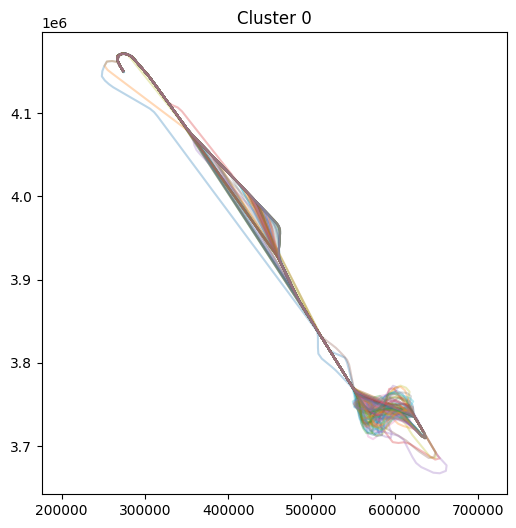

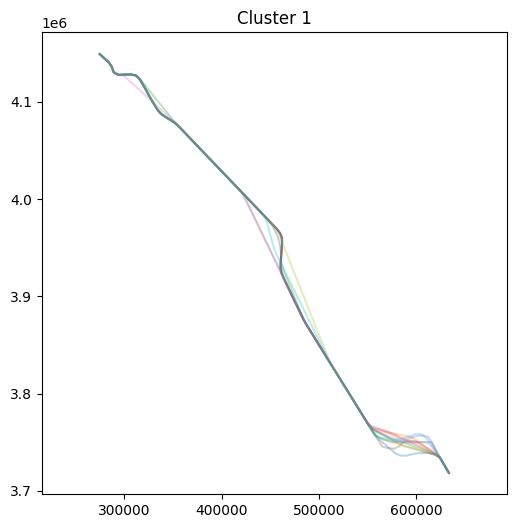

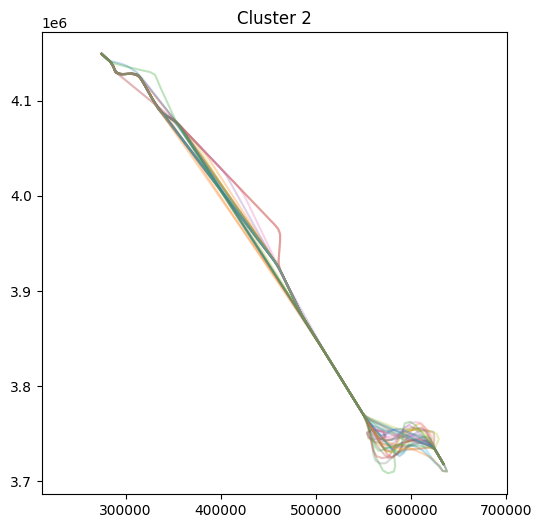

In [41]:
# 시각화

for cluster_id in set(labels):
    if cluster_id == -1:
        continue

    plt.figure(figsize=(6,6))

    for fid, lbl in zip(fids, labels):
        if lbl == cluster_id:
            traj = resampled_trajectories[fid]   # 이미 N개의 (x,y,z)
            xs = [p[0] for p in traj]
            ys = [p[1] for p in traj]
            plt.plot(xs, ys, alpha=0.3)

    plt.title(f"Cluster {cluster_id}")
    plt.axis('equal')
    plt.show()

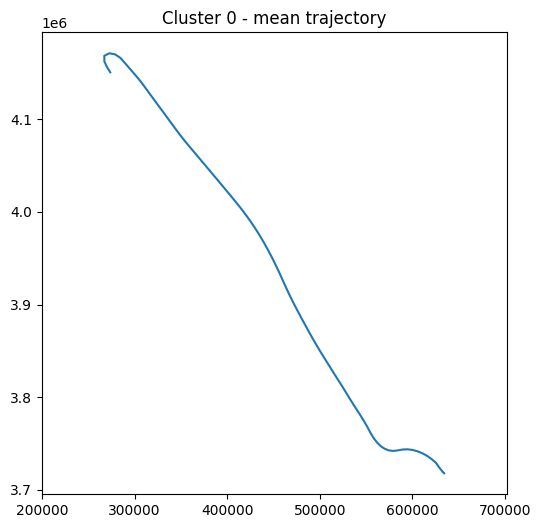

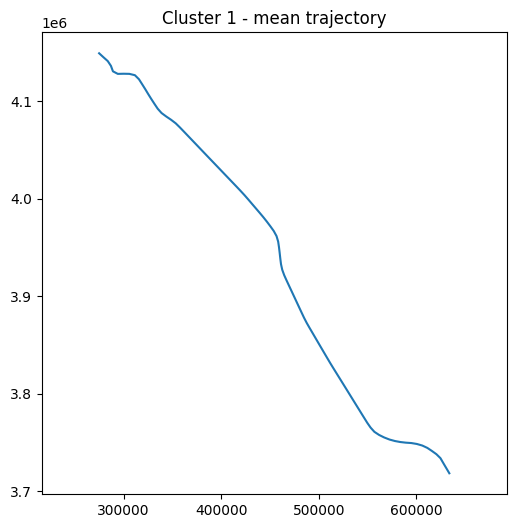

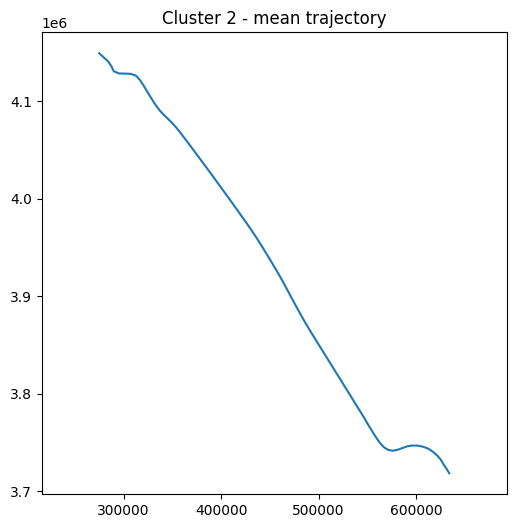

In [42]:
# 대표 경로만 시각화
cluster_ids = sorted([cid for cid in set(labels) if cid != -1])

for cid in cluster_ids:
    member_fids = [fid for fid, lbl in zip(fids, labels) if lbl == cid]

    # (num_members, 100, 3)
    stack = np.array([resampled_trajectories[fid] for fid in member_fids])

    # 평균 경로 (100, 3)
    mean_traj = stack.mean(axis=0)

    xs = mean_traj[:, 0]
    ys = mean_traj[:, 1]

    plt.figure(figsize=(6,6))
    plt.plot(xs, ys)
    plt.title(f"Cluster {cid} - mean trajectory")
    plt.axis('equal')
    plt.show()

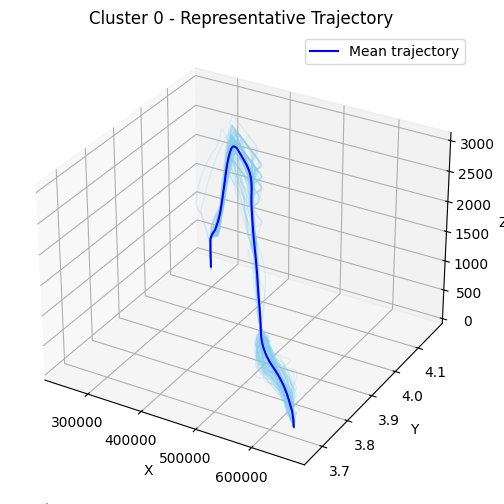

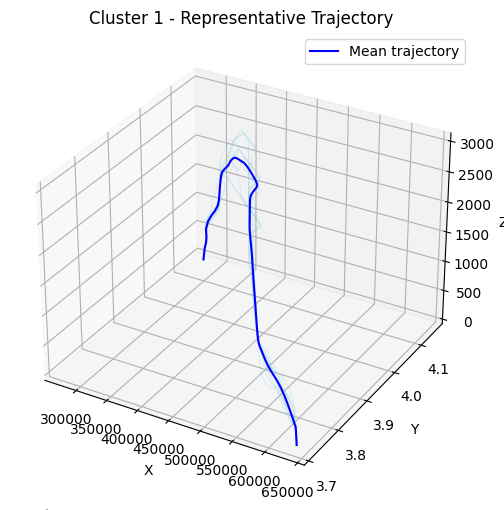

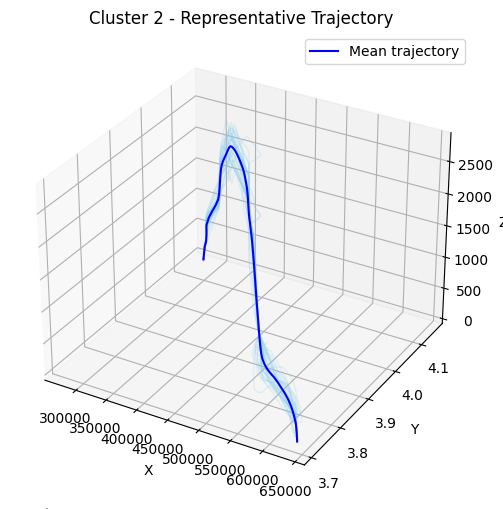

In [43]:
from mpl_toolkits.mplot3d import Axes3D

cluster_ids = sorted([cid for cid in set(labels) if cid != -1])

for cid in cluster_ids:

    member_fids = [fid for fid, lbl in zip(fids, labels) if lbl == cid]
    stack = np.array([resampled_trajectories[fid] for fid in member_fids])  # (N_members, 100, 3)

    # (100, 3)
    mean_traj = stack.mean(axis=0)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 개별 trajectory (연하게)
    for fid in member_fids:
        traj = np.array(resampled_trajectories[fid])
        ax.plot(traj[:,0], traj[:,1], traj[:,2],
                color="skyblue", alpha=0.2, linewidth=1)

    # 대표 trajectory (진하게)
    ax.plot(mean_traj[:,0], mean_traj[:,1], mean_traj[:,2],
            color="blue", linewidth=1.5, label="Mean trajectory")

    ax.set_title(f"Cluster {cid} - Representative Trajectory")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()


In [44]:
# 지도로 시각화 (통합)

# UTM 52N → WGS84
to_wgs84 = Transformer.from_crs("EPSG:32652", "EPSG:4326", always_xy=True)

def utm_to_latlon(x, y):
    lon, lat = to_wgs84.transform(x, y)
    return lat, lon

latlon_trajs = {}

for fid, traj in resampled_trajectories.items():
    latlon = [utm_to_latlon(p[0], p[1]) for p in traj]
    latlon_trajs[fid] = latlon

# 지도 초기화 (대략 중간 위치)
m = folium.Map(location=[35, 130], zoom_start=5)

for cluster_id in set(labels):
    if cluster_id == -1:
        continue

    # cluster members
    cluster_members = [
        fid for fid, lbl in zip(fids, labels) if lbl == cluster_id
    ]

    # folium polyline 색 or 투명도 다르게 설정 가능
    for fid in cluster_members:
        traj = latlon_trajs[fid]   # [(lat, lon), ... ]
        folium.PolyLine(
            traj,
            color="red",
            weight=2,
            opacity=0.4
        ).add_to(m)

m

In [45]:
# 지도로 시각화 (색 구분)

colors = {
    0: "red",
    1: "blue",
    2: "green"
}

m = folium.Map(location=[35, 130], zoom_start=5)

for cluster_id in set(labels):
    if cluster_id == -1:
        continue

    cluster_members = [fid for fid, lbl in zip(fids, labels) if lbl == cluster_id]

    for fid in cluster_members:
        traj = latlon_trajs[fid]
        folium.PolyLine(
            traj,
            color=colors.get(cluster_id, "gray"),
            weight=2,
            opacity=0.6
        ).add_to(m)

m

In [46]:
target_cluster = 0   # ← 여기에 보고 싶은 클러스터 번호 넣기 (0,1,2 중 하나)

# Folium 지도 초기화
m = folium.Map(location=[35, 130], zoom_start=5)

# ------- 1) 평균 경로 계산 -------
member_fids = [fid for fid, lbl in zip(fids, labels) if lbl == target_cluster]

# (num_members, 100, 3)
stack = np.array([resampled_trajectories[fid] for fid in member_fids])

# (100, 3) mean path
mean_traj = stack.mean(axis=0)

# UTM → (lat, lon) 변환
mean_latlon = [utm_to_latlon(p[0], p[1]) for p in mean_traj]

# ------- 2) 먼저 개별 경로(연하게) 추가 -------
for fid in member_fids:
    traj = latlon_trajs[fid]
    folium.PolyLine(
        traj,
        color="gray",
        weight=2,
        opacity=0.6
    ).add_to(m)

# ------- 3) 평균 경로(진하게) 추가 -------
folium.PolyLine(
    mean_latlon,
    color="red",
    weight=2,
    opacity=1.0,
    tooltip=f"Cluster {target_cluster} Mean Trajectory"
).add_to(m)

# 지도 출력
m

In [47]:
target_cluster = 1   # ← 여기에 보고 싶은 클러스터 번호 넣기 (0,1,2 중 하나)

# Folium 지도 초기화
m = folium.Map(location=[35, 130], zoom_start=5)

# ------- 1) 평균 경로 계산 -------
member_fids = [fid for fid, lbl in zip(fids, labels) if lbl == target_cluster]

# (num_members, 100, 3)
stack = np.array([resampled_trajectories[fid] for fid in member_fids])

# (100, 3) mean path
mean_traj = stack.mean(axis=0)

# UTM → (lat, lon) 변환
mean_latlon = [utm_to_latlon(p[0], p[1]) for p in mean_traj]

# ------- 2) 먼저 개별 경로(연하게) 추가 -------
for fid in member_fids:
    traj = latlon_trajs[fid]
    folium.PolyLine(
        traj,
        color="gray",
        weight=2,
        opacity=0.6
    ).add_to(m)

# ------- 3) 평균 경로(진하게) 추가 -------
folium.PolyLine(
    mean_latlon,
    color="blue",
    weight=2,
    opacity=1.0,
    tooltip=f"Cluster {target_cluster} Mean Trajectory"
).add_to(m)

# 지도 출력
m

In [48]:
target_cluster = 2   # ← 여기에 보고 싶은 클러스터 번호 넣기 (0,1,2 중 하나)

# Folium 지도 초기화
m = folium.Map(location=[35, 130], zoom_start=5)

# ------- 1) 평균 경로 계산 -------
member_fids = [fid for fid, lbl in zip(fids, labels) if lbl == target_cluster]

# (num_members, 100, 3)
stack = np.array([resampled_trajectories[fid] for fid in member_fids])

# (100, 3) mean path
mean_traj = stack.mean(axis=0)

# UTM → (lat, lon) 변환
mean_latlon = [utm_to_latlon(p[0], p[1]) for p in mean_traj]

# ------- 2) 먼저 개별 경로(연하게) 추가 -------
for fid in member_fids:
    traj = latlon_trajs[fid]
    folium.PolyLine(
        traj,
        color="gray",
        weight=2,
        opacity=0.6
    ).add_to(m)

# ------- 3) 평균 경로(진하게) 추가 -------
folium.PolyLine(
    mean_latlon,
    color="green",
    weight=2,
    opacity=1.0,
    tooltip=f"Cluster {target_cluster} Mean Trajectory"
).add_to(m)

# 지도 출력
m

In [49]:
import numpy as np
import plotly.graph_objects as go

cluster_ids = sorted([cid for cid in set(labels) if cid != -1])

fig = go.Figure()

# plotly 색상들
colors = ["red", "blue", "green", "purple", "orange", "cyan", "magenta"]

for idx, cid in enumerate(cluster_ids):
    # 해당 클러스터에 속하는 flight ID
    member_fids = [fid for fid, lbl in zip(fids, labels) if lbl == cid]

    # (num_members, 100, 3)
    stack = np.array([resampled_trajectories[fid] for fid in member_fids])

    # 평균 경로 (100, 3)
    mean_traj = stack.mean(axis=0)

    fig.add_trace(go.Scatter3d(
        x=mean_traj[:,0],
        y=mean_traj[:,1],
        z=mean_traj[:,2],
        mode='lines',
        line=dict(color=colors[idx % len(colors)], width=6),
        name=f"Cluster {cid} Mean Trajectory"
    ))

fig.update_layout(
    width=900,
    height=700,
    title="3D Mean Flight Trajectory per Cluster",
    scene=dict(
        xaxis_title="X (UTM)",
        yaxis_title="Y (UTM)",
        zaxis_title="Altitude"
    ),
    showlegend=True
)

fig.show()
